# Initial setup

In [1]:
# Libs for visualization of torch implementations
!pip install torchviz torchinfo -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
from torchviz import make_dot
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import seaborn as sns
import tqdm as tqdm
import warnings
import string
import re

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

print("PyTorch version: ", torch.__version__)
print("CUDA available: ", torch.cuda.is_available())

PyTorch version:  2.6.0+cu124
CUDA available:  True


# Basic RNN

In [3]:
class SimpleRNN:
  """
  Basic RNN (Elman) Network:
  "The hidden layer from the previous time step
    provides a form of memory, or context, that encodes earlier processing"

  - g is activation function (typically tanh or ReLU)
  - f is output function (often softmax for classification)
  - U: hidden-to-hidden weights (recurrent connections)
  - W: input-to-hidden weights
  - V: hidden-to-output weights


  h_t = tanh(W_h @ h_{t-1}   +  x_t + b_h )
  y_t = W_t @ h_t   +   b_y
  """

  def __init__(self, input_size, hidden_size, output_size):

    # W ∈ R^(dh×din): input to hidden weights
    # U ∈ R^(dh×dh): hidden to hidden weights (recurrent)
    # V ∈ R^(dout×dh): hidden to output weights

    # Initializing weght matrices with small random values (not zero)

    # W matrix
    self.W_x = np.random.randn(hidden_size, input_size) * 0.01 # Weight matrix W: Input to hidden

    # U matrix
    self.W_h = np.random.randn(hidden_size, hidden_size) * 0.01 # Weight matrix U:  Hidden to hidden (recurrent)

    # V matrix
    self.W_y = np.random.randn(output_size, hidden_size) * 0.01 # Weight matrix V:  hidden to output


    # Initizalizing biases
    self.b_h = np.zeros((hidden_size, 1))
    self.b_y = np.zeros((output_size, 1))

    # Storing the dimensions
    self.input_size = input_size    # dh
    self.hidden_size = hidden_size  # din
    self.output_size =  output_size # dout


  def forward_step(self, x_t, h_prev):
    """
    Single foward step

      "The key difference from a feedforward network lies
        in the recurrent link... This link augments the input to the computation
        at the hidden layer with the value of the hidden layer from the preceding
        point in time.
      "
    x_t: input at time t, shape (input_size,1)
    h_prev: h_{t-1}, shape (hidden_size,1)

    """

    # h_t = g(Uh_{t-1} + Wx_t)
    h_t = np.tanh(self.W_h @ h_prev + self.W_x @ x_t + self.b_h)


    # y_t = f(Vh_t) with f = identity function
    y_t = self.W_y @ h_t + self.b_y

    return h_t, y_t


  def forward(self, X):
    """
    Forward inference algorithm

    X: input sequence, shape (sequence_length, input_size)
    Returns: all hidden states and outputs
    """

    seq_len = X.shape[0]
    print("seq_len: ", seq_len )

    # Initialize h_0 to zero vector
    h_t = np.zeros((self.hidden_size, 1))

    # Store the hidden states
    hidden_states = []
    outputs = []

    # Process sequence incrementally
    for t in range(seq_len):
      x_t = X[t].reshape(-1,1) # each input at time t
      h_t, y_t = self.forward_step(x_t, h_t)
      hidden_states.append(h_t)
      outputs = y_t

    return(hidden_states, outputs)

  def __repr__(self):
    return(f" input_size: {self.input_size}, hidden_size: {self.hidden_size}, output_size: {self.output_size}")



## Simple test

In [4]:
print("Testing Simple RNN (Elman Network):")

rnn = SimpleRNN(input_size=10, hidden_size=20, output_size=5)
print(rnn)

# Dummy sequence data
seq_length = 8
input_dim = 10
X_dummy = np.random.randn(seq_length, input_dim)

hidden_states, outputs = rnn.forward(X_dummy)

print("hidden_states:  \n", np.array(hidden_states).squeeze() ," \n")

print("outputs:  \n", outputs  ," \n")


Testing Simple RNN (Elman Network):
 input_size: 10, hidden_size: 20, output_size: 5
seq_len:  8
hidden_states:  
 [[-1.56081945e-02  5.95810965e-02  4.75588180e-02  1.12944884e-02
   9.03093238e-03 -5.01355034e-03  2.08244004e-02 -3.76964285e-03
   2.51082922e-02  1.31507002e-02 -6.05396027e-03 -5.15986770e-02
  -7.54125228e-03 -9.88496143e-05  8.77580527e-03  1.53162189e-02
   1.93337792e-02  6.94202654e-02 -1.91136593e-02  2.04048482e-02]
 [ 6.34173100e-03 -1.28248123e-02  7.01809897e-05 -2.01024955e-02
  -3.93462650e-03  1.38291630e-02  1.61096683e-02  1.46039358e-02
  -1.26956802e-02 -1.37624339e-02  2.57023386e-03  3.97026773e-03
   8.35553545e-03  1.88369971e-02  9.93429045e-03  3.45102461e-03
  -3.11167240e-03  1.02954915e-02  2.29764868e-02 -4.12029622e-03]
 [ 7.15034573e-03  4.67259062e-03  1.85002138e-03 -3.86306561e-02
   1.31091348e-02  1.11024640e-02  1.27229907e-02 -5.21397162e-03
  -2.99907016e-02 -3.54050074e-03  7.35827151e-04 -5.43135429e-03
  -1.30321911e-02  1.2667

### Heatmap visualization


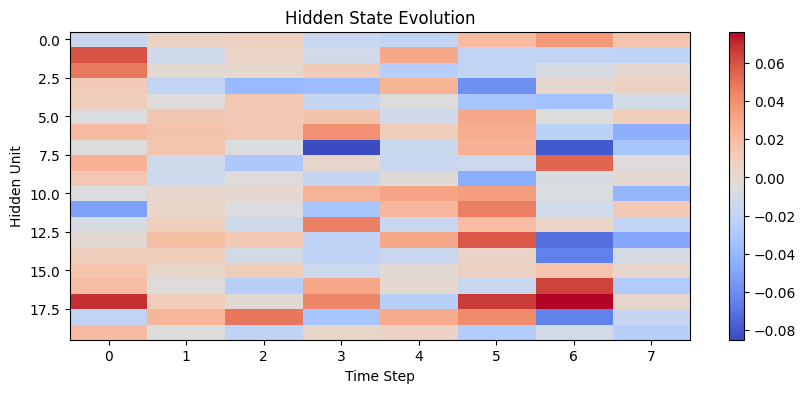

In [5]:
hidden_array = np.array(hidden_states).squeeze()
"""
Dead neurons: Horizontal lines that stay near 0 (blue/cold) indicate unused hidden units
Active neurons: Bright red/blue bands show which units are doing the work
Saturation: Very bright areas might indicate saturated neurons (stuck at ±1 with tanh)
"""
plt.figure(figsize=(10, 4))
plt.imshow(hidden_array.T, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time Step')
plt.ylabel('Hidden Unit')
plt.title('Hidden State Evolution')
plt.show()



# Long Short Term Memory

 Fixes 2 issues from the RNNs:
 - RNNs having issues with long distance dependencies
 - Vanishing gradients problem on training


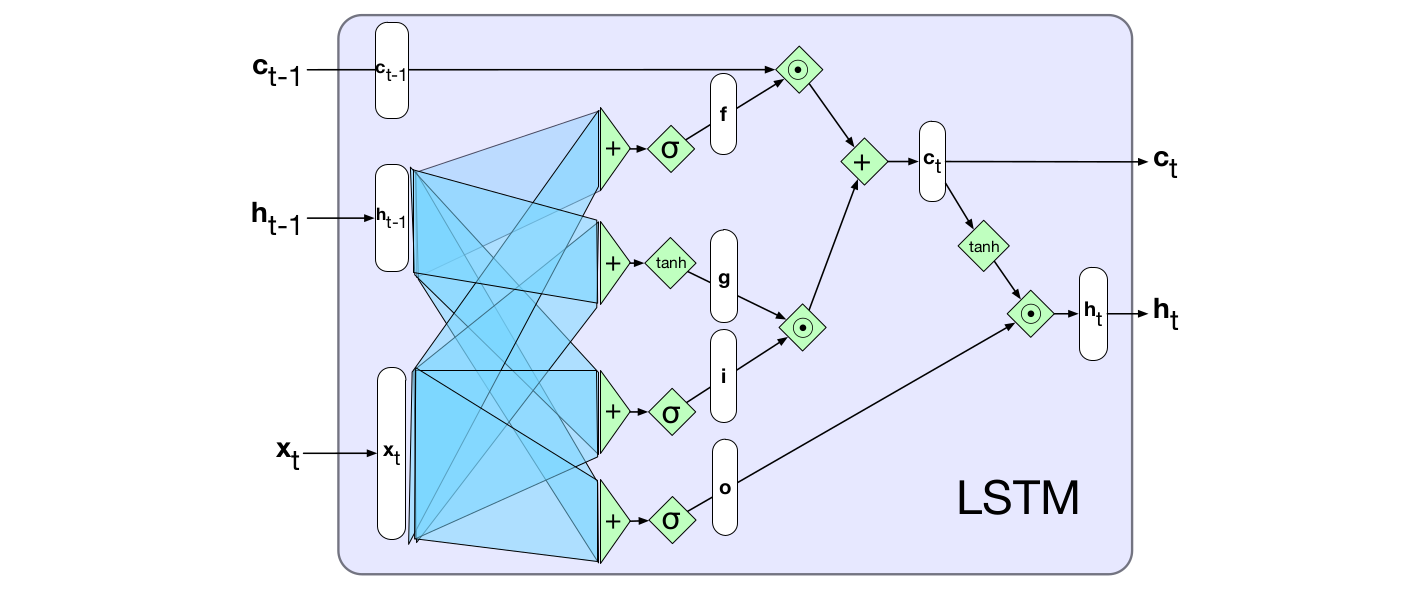

In [6]:
def sigmoid(x):
  """The choice of the sigmoid as the activation function arises from
    its tendency to push its outputs to either 0 or 1... similar to a binary mask"""
  z = np.clip(x, -500,500)
  return(1/(1+np.exp(-z)))


In [7]:
class LSTMCell:
  """
  LSTMs divide the context management problem into
      two subproblems: removing information no longer needed from the context,
      and adding information likely to be needed for later decision making.
  The gates implement these functions:
  - Forget gate: controls what to remove from the context
  - Input (Add) Gate: controls what new info to add to context
  - Output Gate: controls what info is needed for current output
  """
  def __init__(self, input_size, hidden_size):

    # concatenated input size [h_{t-1}, x_t]
    concat_size = hidden_size + input_size # This concatenation is fed to all LSTM gates (forget, input, output gates) as per the LSTM equations. Each gate needs both previous state and current input to make decisions.

    # Forget gate weights f_t = σ(U_f h_{t-1} + W_f x_t))
    self.W_f = np.random.randn(hidden_size, concat_size) * 0.01 # combines U_f and W_f

    # Input gate weights i_t = σ(U_i h_{t-1} + W_i x_t))
    self.W_i = np.random.randn(hidden_size, concat_size) * 0.01 # combines U_i and W_i

    # Candidate values weights (Equation 8.22: g_t = tanh(U_g h_{t-1} + W_g x_t))
    self.W_g = np.random.randn(hidden_size, concat_size) * 0.01 # combines U_g and W_g

    # Output gate weights  o_t = σ(U_o h_{t-1} + W_o x_t))
    self.W_o = np.random.randn(hidden_size, concat_size) * 0.01 # combines U_o and W_o

    # Initialize biases
    self.b_f = np.zeros((hidden_size, 1))
    self.b_i = np.zeros((hidden_size, 1))
    self.b_g = np.zeros((hidden_size, 1))
    self.b_o = np.zeros((hidden_size, 1))
    self.hidden_size = hidden_size
    self.input_size = input_size

  def forward(self, x_t, h_prev, c_prev):
    """
    Forward pass in LSTM:
    1. Forget gate removes unnecessary info from previous context
    2. Input gate selects new information to add
    3. Cell state combines retained old info with selected new info
    4. Output gate determines what's needed for current output

    x_t: input at time t, shape (input_size, 1)
    h_prev: previous hidden state h_{t-1}, shape (hidden_size, 1)
    c_prev: previous cell state c_{t-1}, shape (hidden_size, 1)
    """

    #  Concat inputs with  f_t = σ(U_f h_{t-1} + W_f x_t)
    # This concatenation is fed to all LSTM gates (forget, input, output gates) as per the LSTM equations. Each gate needs both previous state and current input to make decisions.
    concat = np.vstack([h_prev, x_t])# Shape: (hidden_size + input_size, 1)
    print(f"\n  Concatenated input shape: {concat.shape} = [{h_prev.shape[0]} + {x_t.shape[0]}, 1]")

    # Forget gate computation
    print(f"\n  Forget gate: W_f{self.W_f.shape} @ concat{concat.shape} + b_f{self.b_f.shape}")
    linear_f = self.W_f @ concat + self.b_f
    print(f"    Linear output (before sigmoid): {linear_f[:3, 0].round(3)}")
    f_t = sigmoid(linear_f)
    print(f"    Forget gate output (after sigmoid): {f_t[:3, 0].round(3)}")

    # Input gate computation
    print(f"\n  Input gate: W_i{self.W_i.shape} @ concat{concat.shape} + b_i{self.b_i.shape}")
    linear_i = self.W_i @ concat + self.b_i
    print(f"    Linear output (before sigmoid): {linear_i[:3, 0].round(3)}")
    i_t = sigmoid(linear_i)
    print(f"    Input gate output (after sigmoid): {i_t[:3, 0].round(3)}")

    # Candidate values. "Compute the actual information we need to extract from the previous hidden state and current inputs"
    print(f"\n  Candidate values: W_g{self.W_g.shape} @ concat{concat.shape} + b_g{self.b_g.shape}")
    linear_g = self.W_g @ concat + self.b_g
    print(f"    Linear output (before tanh): {linear_g[:3, 0].round(3)}")
    g_t = np.tanh(linear_g)
    print(f"    Candidate values (after tanh): {g_t[:3, 0].round(3)}")

    # Output gate. "Used to decide what information is required for the current hidden state (as opposed to what information needs to be preserved)"
    print(f"\n  Output gate: W_o{self.W_o.shape} @ concat{concat.shape} + b_o{self.b_o.shape}")
    linear_o = self.W_o @ concat + self.b_o
    print(f"    Linear output (before sigmoid): {linear_o[:3, 0].round(3)}")
    o_t = sigmoid(linear_o)
    print(f"    Output gate output (after sigmoid): {o_t[:3, 0].round(3)}")

    # Update cell state with element-wise multiplications (Hadamard product)
    # c_t = f_t ⊙ c_{t-1} + i_t ⊙ g_t
    print(f"\n\n  Cell state update:")
    forget_part = f_t * c_prev
    input_part = i_t * g_t
    print(f"    Forget part (f_t * c_prev): {forget_part[:3, 0].round(3)}")
    print(f"    Input part (i_t * g_t): {input_part[:3, 0].round(3)}")
    c_t = forget_part + input_part
    print(f"    New cell state c_t: {c_t[:3, 0].round(3)}")

    # Compute hidden state. "The hidden state h_t provides the output for the LSTM at each time step"
    # h_t = o_t ⊙ tanh(c_t)
    print(f"\n\n  Hidden state computation:")
    tanh_c = np.tanh(c_t)
    print(f"    tanh(c_t): {tanh_c[:3, 0].round(3)}")
    h_t = o_t * tanh_c
    print(f"    Final hidden state h_t (o_t * tanh(c_t)): {h_t[:3, 0].round(3)}")

    return(h_t, c_t, (f_t, i_t, g_t, o_t))

### Simple Test of LSTM Cell


In [8]:
print("Testing LSTM Cell:")
print("Book: 'The most commonly used extension to RNNs is the \nLong Short-Term Memory (LSTM) network (Hochreiter and Schmidhuber, 1997)'")
lstm_cell = LSTMCell(input_size=10, hidden_size=20)

# Initialize states
h_prev = np.zeros((20,1))
c_prev = np.zeros((20,1))
x_t = np.zeros((10,1))

print("\nProcessing single timestep:")
h_t, c_t, gates = lstm_cell.forward(x_t, h_prev, c_prev)
print(f"\nHidden state shape: {h_t.shape}")
print(f"\nCell state shape: {c_t.shape}")
print("\nNote: Cell state c_t acts as the long-term memory")

Testing LSTM Cell:
Book: 'The most commonly used extension to RNNs is the 
Long Short-Term Memory (LSTM) network (Hochreiter and Schmidhuber, 1997)'

Processing single timestep:

  Concatenated input shape: (30, 1) = [20 + 10, 1]

  Forget gate: W_f(20, 30) @ concat(30, 1) + b_f(20, 1)
    Linear output (before sigmoid): [0. 0. 0.]
    Forget gate output (after sigmoid): [0.5 0.5 0.5]

  Input gate: W_i(20, 30) @ concat(30, 1) + b_i(20, 1)
    Linear output (before sigmoid): [0. 0. 0.]
    Input gate output (after sigmoid): [0.5 0.5 0.5]

  Candidate values: W_g(20, 30) @ concat(30, 1) + b_g(20, 1)
    Linear output (before tanh): [0. 0. 0.]
    Candidate values (after tanh): [0. 0. 0.]

  Output gate: W_o(20, 30) @ concat(30, 1) + b_o(20, 1)
    Linear output (before sigmoid): [0. 0. 0.]
    Output gate output (after sigmoid): [0.5 0.5 0.5]


  Cell state update:
    Forget part (f_t * c_prev): [0. 0. 0.]
    Input part (i_t * g_t): [0. 0. 0.]
    New cell state c_t: [0. 0. 0.]


  Hi

# PyTorch RNN Implementation

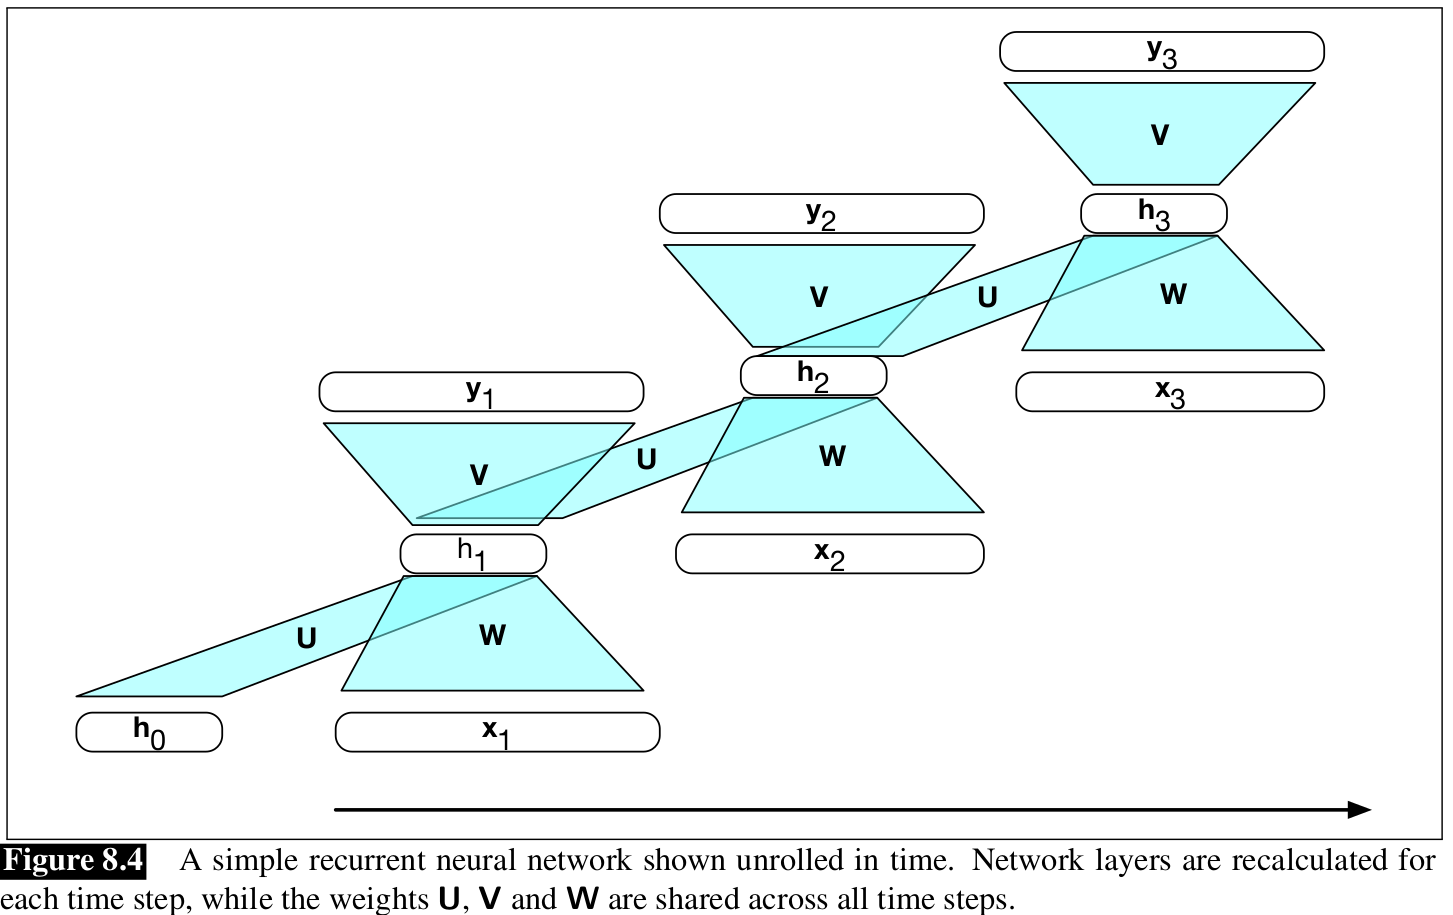

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNLanguageModel(nn.Module):
  """
  RNN-based Language Model, process the input sequence one-word at a time
  Predicts next word from current word and previous hidden state

  Architecture:
  1. Word embedding: e_t = Ex_t
  2. Hidden state: h_t = g(Uh_{t-1} + We_t)
  3. Output: ŷ_t = softmax(Vh_t)

  With weight tying : V = E^T for parameter efficiency
  """

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.2):
    super(RNNLanguageModel, self).__init__()

    print(f"\n{'='*60}")
    print("Initializing RNN Language Model")
    print(f"{'='*60}")
    print(f"  Vocab size: {vocab_size}")
    print(f"  Embedding dim: {embedding_dim}")
    print(f"  Hidden dim: {hidden_dim}")
    print(f"  Num layers: {num_layers}")
    print(f"  Dropout: {dropout}")

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    print(f"\n  Embedding matrix shape: {vocab_size} x {embedding_dim}")

    # RNN layer with recurrent computation
    # Can use variants: vanilla RNN, LSTM, or GRU
    self.rnn = nn.RNN(
        embedding_dim,  # Input size = emb dim
        hidden_dim,  # dim d
        num_layers,  # can stack multiple rnn layers
        batch_first=True,  # input shape: (batch, seq, features)
        dropout=dropout if num_layers > 1 else 0  # dropout to avoid overfitting
    )
    print(f"  RNN layers: {num_layers} layers of {embedding_dim} -> {hidden_dim}")

    # output layer "V"
    # Maps hidden state to vocab scores
    self.fc = nn.Linear(hidden_dim, vocab_size)  # fully connected
    print(f"  Output layer (V): {hidden_dim} -> {vocab_size}")

    # dropout for regularization
    self.dropout = nn.Dropout(dropout)

    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim

  def forward(self, x, hidden=None):
    """
    Forward pass
    x: input indices, shape (batch_size, sequence_length)
    hidden: initial hidden state (h_0 in the book)
    """
    print(f"\n{'='*60}")
    print("Forward Pass Through RNN Language Model")
    print(f"{'='*60}")

    batch_size = x.size(0)
    seq_len = x.size(1)
    print(f"\n1. Input:")
    print(f"   Input shape: {x.shape} (batch_size={batch_size}, seq_len={seq_len})")
    print(f"   Sample input indices: {x[0, :5].tolist() if seq_len >= 5 else x[0].tolist()}")

    # Initialize hidden state if not provided
    if hidden is None:
      hidden = self.init_hidden(batch_size)
      print(f"\n   Initialized hidden state h_0: {hidden.shape}")
    else:
      print(f"\n   Using provided hidden state: {hidden.shape}")

    # Get word embeddings for input seq
    # e_t = Emb matrix.x_t, id matrix that gets the embeddings per words
    print(f"\n2. Embedding Lookup (e_t = E[x_t]):")
    print(f"   Embedding matrix E: ({self.vocab_size}, {self.embedding_dim})")
    embedded = self.embedding(x)  # shape(batch, seq_len, embedding_dim)
    print(f"   Embedded output shape: {embedded.shape}")
    print(f"   (batch={batch_size}, seq={seq_len}, emb_dim={self.embedding_dim})")

    embedded = self.dropout(embedded)
    print(f"   After dropout: {embedded.shape}")

    # RNN processes seq and updates hidden states
    # h_t = g(Uh_{t-1} + We_t)
    print(f"\n3. RNN Computation (h_t = g(Uh_{{t-1}} + We_t)):")
    print(f"   Input to RNN: {embedded.shape}")
    print(f"   Hidden state input: {hidden.shape}")
    print(f"   Inside RNN:")
    print(f"     U (hidden-to-hidden): ({self.hidden_dim}, {self.hidden_dim})")
    print(f"     W (input-to-hidden): ({self.hidden_dim}, {self.embedding_dim})")

    rnn_out, hidden = self.rnn(embedded, hidden)
    print(f"\n   RNN output shape: {rnn_out.shape}")
    print(f"   (batch={batch_size}, seq={seq_len}, hidden={self.hidden_dim})")
    print(f"   Final hidden state: {hidden.shape}")
    print(f"   (num_layers={self.num_layers}, batch={batch_size}, hidden={self.hidden_dim})")

    # Dropout
    rnn_out = self.dropout(rnn_out)
    print(f"   After dropout: {rnn_out.shape}")

    # Reshape output layer
    print(f"\n4. Reshape for Output Layer:")
    print(f"   Before reshape: {rnn_out.shape}")
    rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim)  # contiguous() ensures tensor memory is stored sequentially
    print(f"   After reshape: {rnn_out.shape}")
    print(f"   ({batch_size * seq_len}, {self.hidden_dim})")

    # Vocab scores in softmax with loss
    # ŷ_t = softmax(Vh_t)
    print(f"\n5. Output Layer (ŷ_t = softmax(Vh_t)):")
    print(f"   V matrix (fc layer): ({self.vocab_size}, {self.hidden_dim})")
    print(f"   Input to fc: {rnn_out.shape}")

    output = self.fc(rnn_out)  # (batch * seq_len, vocab_size)
    print(f"   Output logits shape: {output.shape}")
    print(f"   ({batch_size * seq_len}, vocab_size={self.vocab_size})")
    print(f"\n   Note: Softmax will be applied during loss computation")

    print(f"\n{'='*60}")

    return output, hidden

  def init_hidden(self, batch_size):
    """Initialize hidden state h_0 with zeros"""
    return torch.zeros(self.num_layers, batch_size, self.hidden_dim)


### Simple test

In [10]:
# Test the model
print("\n" + "="*70)
print("TESTING RNN LANGUAGE MODEL")
print("="*70)

vocab_size = 100
model = RNNLanguageModel(vocab_size, embedding_dim=50, hidden_dim=128, num_layers=2)

print(f"\n{'='*60}")
print("Model Architecture Summary:")
print(f"{'='*60}")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")



TESTING RNN LANGUAGE MODEL

Initializing RNN Language Model
  Vocab size: 100
  Embedding dim: 50
  Hidden dim: 128
  Num layers: 2
  Dropout: 0.2

  Embedding matrix shape: 100 x 50
  RNN layers: 2 layers of 50 -> 128
  Output layer (V): 128 -> 100

Model Architecture Summary:
RNNLanguageModel(
  (embedding): Embedding(100, 50)
  (rnn): RNN(50, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=100, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 73,964


### Test forward pass with sample input


In [11]:
print(f"\n{'='*60}")
print("TEST FORWARD PASS")
print(f"{'='*60}")

batch_size = 2
seq_length = 10
sample_input = torch.randint(0, vocab_size, (batch_size, seq_length))

output, final_hidden = model(sample_input)

print(f"\nFinal Summary:")
print(f"  Input shape: {sample_input.shape}")
print(f"  Output shape: {output.shape} (ready for CrossEntropyLoss)")
print(f"  Hidden state shape: {final_hidden.shape}")


TEST FORWARD PASS

Forward Pass Through RNN Language Model

1. Input:
   Input shape: torch.Size([2, 10]) (batch_size=2, seq_len=10)
   Sample input indices: [22, 96, 44, 16, 57]

   Initialized hidden state h_0: torch.Size([2, 2, 128])

2. Embedding Lookup (e_t = E[x_t]):
   Embedding matrix E: (100, 50)
   Embedded output shape: torch.Size([2, 10, 50])
   (batch=2, seq=10, emb_dim=50)
   After dropout: torch.Size([2, 10, 50])

3. RNN Computation (h_t = g(Uh_{t-1} + We_t)):
   Input to RNN: torch.Size([2, 10, 50])
   Hidden state input: torch.Size([2, 2, 128])
   Inside RNN:
     U (hidden-to-hidden): (128, 128)
     W (input-to-hidden): (128, 50)

   RNN output shape: torch.Size([2, 10, 128])
   (batch=2, seq=10, hidden=128)
   Final hidden state: torch.Size([2, 2, 128])
   (num_layers=2, batch=2, hidden=128)
   After dropout: torch.Size([2, 10, 128])

4. Reshape for Output Layer:
   Before reshape: torch.Size([2, 10, 128])
   After reshape: torch.Size([20, 128])
   (20, 128)

5. Ou

## Visualization

In [12]:
# Method 1: Using torchinfo for detailed summary
dummy_input = torch.randint(0, vocab_size, (2, 10))  # batch_size=2, seq_len=10
print("\nModel Summary using torchinfo:")
summary(model, input_data=dummy_input,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        depth=3, verbose=0)



Model Summary using torchinfo:

Forward Pass Through RNN Language Model

1. Input:
   Input shape: torch.Size([2, 10]) (batch_size=2, seq_len=10)
   Sample input indices: [61, 40, 17, 60, 86]

   Initialized hidden state h_0: torch.Size([2, 2, 128])

2. Embedding Lookup (e_t = E[x_t]):
   Embedding matrix E: (100, 50)
   Embedded output shape: torch.Size([2, 10, 50])
   (batch=2, seq=10, emb_dim=50)
   After dropout: torch.Size([2, 10, 50])

3. RNN Computation (h_t = g(Uh_{t-1} + We_t)):
   Input to RNN: torch.Size([2, 10, 50])
   Hidden state input: torch.Size([2, 2, 128])
   Inside RNN:
     U (hidden-to-hidden): (128, 128)
     W (input-to-hidden): (128, 50)

   RNN output shape: torch.Size([2, 10, 128])
   (batch=2, seq=10, hidden=128)
   Final hidden state: torch.Size([2, 2, 128])
   (num_layers=2, batch=2, hidden=128)
   After dropout: torch.Size([2, 10, 128])

4. Reshape for Output Layer:
   Before reshape: torch.Size([2, 10, 128])
   After reshape: torch.Size([20, 128])
   (20

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
RNNLanguageModel                         [2, 10]                   [20, 100]                 --                        True
├─Embedding: 1-1                         [2, 10]                   [2, 10, 50]               5,000                     True
├─Dropout: 1-2                           [2, 10, 50]               [2, 10, 50]               --                        --
├─RNN: 1-3                               [2, 10, 50]               [2, 10, 128]              56,064                    True
├─Dropout: 1-4                           [2, 10, 128]              [2, 10, 128]              --                        --
├─Linear: 1-5                            [20, 128]                 [20, 100]                 12,900                    True
Total params: 73,964
Trainable params: 73,964
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.39
Input size (MB): 0.00


 Creating Computation Graph...

Forward Pass Through RNN Language Model

1. Input:
   Input shape: torch.Size([1, 5]) (batch_size=1, seq_len=5)
   Sample input indices: [33, 73, 41, 25, 22]

   Initialized hidden state h_0: torch.Size([2, 1, 128])

2. Embedding Lookup (e_t = E[x_t]):
   Embedding matrix E: (100, 50)
   Embedded output shape: torch.Size([1, 5, 50])
   (batch=1, seq=5, emb_dim=50)
   After dropout: torch.Size([1, 5, 50])

3. RNN Computation (h_t = g(Uh_{t-1} + We_t)):
   Input to RNN: torch.Size([1, 5, 50])
   Hidden state input: torch.Size([2, 1, 128])
   Inside RNN:
     U (hidden-to-hidden): (128, 128)
     W (input-to-hidden): (128, 50)

   RNN output shape: torch.Size([1, 5, 128])
   (batch=1, seq=5, hidden=128)
   Final hidden state: torch.Size([2, 1, 128])
   (num_layers=2, batch=1, hidden=128)
   After dropout: torch.Size([1, 5, 128])

4. Reshape for Output Layer:
   Before reshape: torch.Size([1, 5, 128])
   After reshape: torch.Size([5, 128])
   (5, 128)

5. O

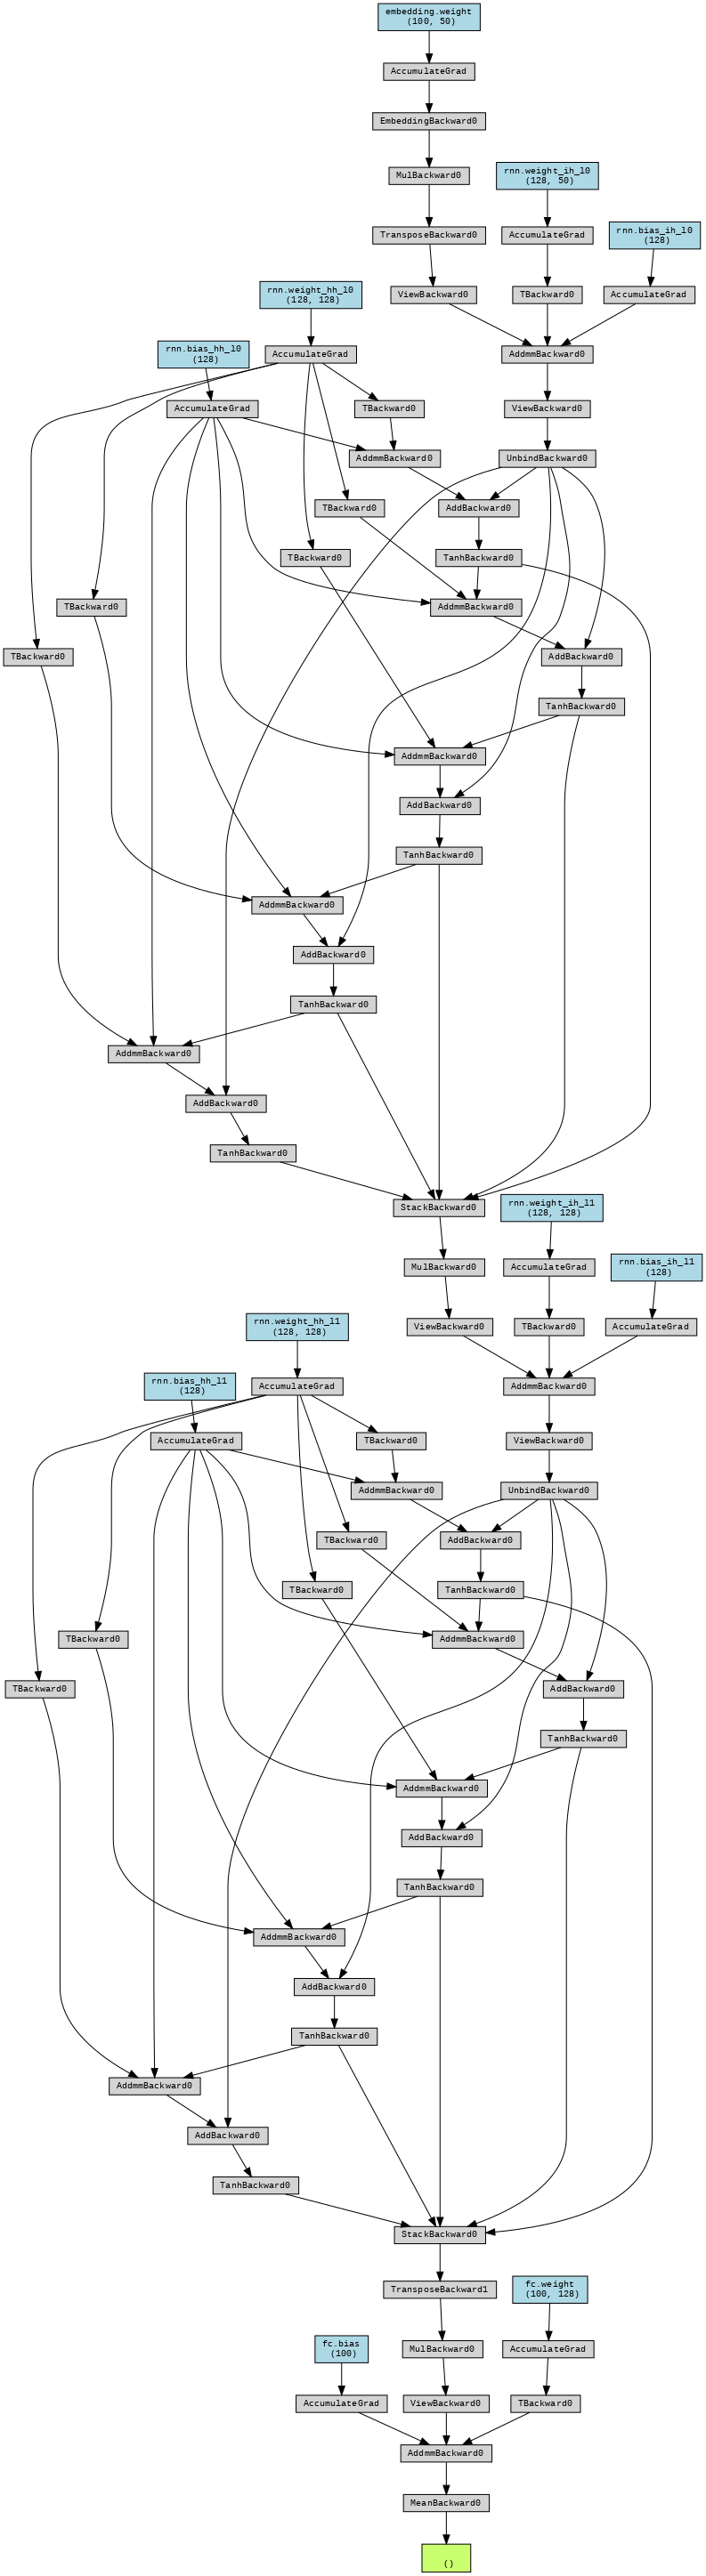

In [13]:
# Method 2: Create computation graph with torchviz
print("\n Creating Computation Graph...")

# Forward pass to create graph
dummy_input = torch.randint(0, vocab_size, (1, 5))  # Smaller for cleaner graph
output, hidden = model(dummy_input)

# Create the graph
graph = make_dot(output.mean(), params=dict(model.named_parameters()))
graph.render("rnn_language_model", format="png", cleanup=True)
print("Graph saved as 'rnn_language_model.png'")

# Display the graph
from IPython.display import Image, display
display(Image('rnn_language_model.png'))

#LSTM for Text Classification

In [14]:
class LSTMClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2, bidirectional=True, dropout=0.3):
    super(LSTMClassifier, self).__init__()

    # Embedding layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # LSTM layer
    self.lstm = nn.LSTM(
        embedding_dim,
        hidden_dim,
        num_layers,
        bidirectional=bidirectional,
        batch_first=True,
        dropout=dropout if num_layers > 1 else 0
    )

    # bidirectional concat if True
    self.fc = nn.Linear (
        hidden_dim * 2 if bidirectional else hidden_dim,
        output_dim
    )

    self.dropout = nn.Dropout(dropout)
    self.bidirectional = bidirectional
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim

  def forward(self, text, text_lengths=None):
    """
      Forward pass for sequence classification

      text: input indices, shape (batch_size, max_seq_length)
      text_lengths: actual lengths for packing (handles variable length)

    """
    batch_size = text.size(0)
    seq_len = text.size(1)

    print(f"\nForward pass: batch_size={batch_size}, max_seq_len={seq_len}")

    # get embeddings
    embedded = self.embedding(text)  # (batch, seq_len, embedding_dim)
    print(f"After embedding: {embedded.shape}")

    embedded = self.dropout(embedded)

    # Pack sequences for efficiency processing of variable lengths
    if text_lengths is not None:
      print(f"Packing sequences with actual lengths: {text_lengths.tolist()}")
      embedded = pack_padded_sequence(
          embedded,
          text_lengths.cpu(),
          batch_first=True,
          enforce_sorted=False
      )

    # Pass through LSTM
    packed_output, (hidden, cell) = self.lstm(embedded)

    # hidden shape: (num_layers * num_directions, batch, hidden_dim)
    print(f"\nLSTM output hidden shape: {hidden.shape}")
    print(f"Shape breakdown: ({self.num_layers} * {'2' if self.bidirectional else '1'}, {batch_size}, {self.hidden_dim})")

    if self.bidirectional:
      # Combine final forward and backward states
      print("\nCombining bidirectional states:")
      print(f"Forward (layer -2): {hidden[-2,:,:].shape}")
      print(f"Backward (layer -1): {hidden[-1,:,:].shape}")
      hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
      print(f"Combined hidden: {hidden.shape}")
    else:
      # Use the last layer's hidden state
      hidden = hidden[-1,:,:]
      print(f"\nUsing final hidden state: {hidden.shape}")

    # Apply dropout and classify
    hidden = self.dropout(hidden)
    output = self.fc(hidden)
    print(f"Final output: {output.shape} (batch_size, num_classes)")

    return output


## Simple test

In [15]:
print("\nTesting LSTM Classifier\n")
print("-" * 40)

vocab_size = 1000
embedding_dim = 100
hidden_dim = 128
output_dim = 3  # 3 classes for classification
batch_size = 4
seq_length = 20

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)

# Create sample input
sample_text = torch.randint(0, vocab_size, (batch_size, seq_length))
sample_lengths = torch.tensor([20, 18, 15, 10])  # Variable lengths

print("\nRunning test forward pass\n")
output = model(sample_text, sample_lengths)


print(f"\nClassification complete: {output.shape}\n")
print("Ready for CrossEntropyLoss with target labels")

print("output: \n", output)


Testing LSTM Classifier

----------------------------------------

Running test forward pass


Forward pass: batch_size=4, max_seq_len=20
After embedding: torch.Size([4, 20, 100])
Packing sequences with actual lengths: [20, 18, 15, 10]

LSTM output hidden shape: torch.Size([4, 4, 128])
Shape breakdown: (2 * 2, 4, 128)

Combining bidirectional states:
Forward (layer -2): torch.Size([4, 128])
Backward (layer -1): torch.Size([4, 128])
Combined hidden: torch.Size([4, 256])
Final output: torch.Size([4, 3]) (batch_size, num_classes)

Classification complete: torch.Size([4, 3])

Ready for CrossEntropyLoss with target labels
output: 
 tensor([[-0.0588,  0.0356, -0.0911],
        [-0.0407,  0.0984, -0.0274],
        [ 0.0204,  0.0332, -0.0149],
        [-0.0466,  0.0944, -0.0223]], grad_fn=<AddmmBackward0>)


# Test and visualization

In [16]:
# Create classifier instance
classifier = LSTMClassifier(
    vocab_size=1000,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=2,
    bidirectional=True
)

print("\n" + "="*60)
print("LSTM CLASSIFIER ARCHITECTURE")
print("="*60)

# Summary
dummy_input = torch.randint(0, 1000, (4, 20))  # batch=4, seq_len=20
print("\n Model Summary:")
summary(classifier, input_data=dummy_input,
        col_names=['input_size', 'output_size', 'num_params'],
        depth=3, verbose=0)


LSTM CLASSIFIER ARCHITECTURE

 Model Summary:

Forward pass: batch_size=4, max_seq_len=20
After embedding: torch.Size([4, 20, 100])

LSTM output hidden shape: torch.Size([4, 4, 128])
Shape breakdown: (2 * 2, 4, 128)

Combining bidirectional states:
Forward (layer -2): torch.Size([4, 128])
Backward (layer -1): torch.Size([4, 128])
Combined hidden: torch.Size([4, 256])
Final output: torch.Size([4, 2]) (batch_size, num_classes)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMClassifier                           [4, 20]                   [4, 2]                    --
├─Embedding: 1-1                         [4, 20]                   [4, 20, 100]              100,000
├─Dropout: 1-2                           [4, 20, 100]              [4, 20, 100]              --
├─LSTM: 1-3                              [4, 20, 100]              [4, 20, 256]              630,784
├─Dropout: 1-4                           [4, 256]                  [4, 256]                  --
├─Linear: 1-5                            [4, 256]                  [4, 2]                    514
Total params: 731,298
Trainable params: 731,298
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 50.86
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 2.93
Estimated Total Size (MB): 3.15


Creating LSTM Computation Graph...

Forward pass: batch_size=1, max_seq_len=10
After embedding: torch.Size([1, 10, 100])

LSTM output hidden shape: torch.Size([4, 1, 128])
Shape breakdown: (2 * 2, 1, 128)

Combining bidirectional states:
Forward (layer -2): torch.Size([1, 128])
Backward (layer -1): torch.Size([1, 128])
Combined hidden: torch.Size([1, 256])
Final output: torch.Size([1, 2]) (batch_size, num_classes)
Graph saved as 'lstm_classifier.png'


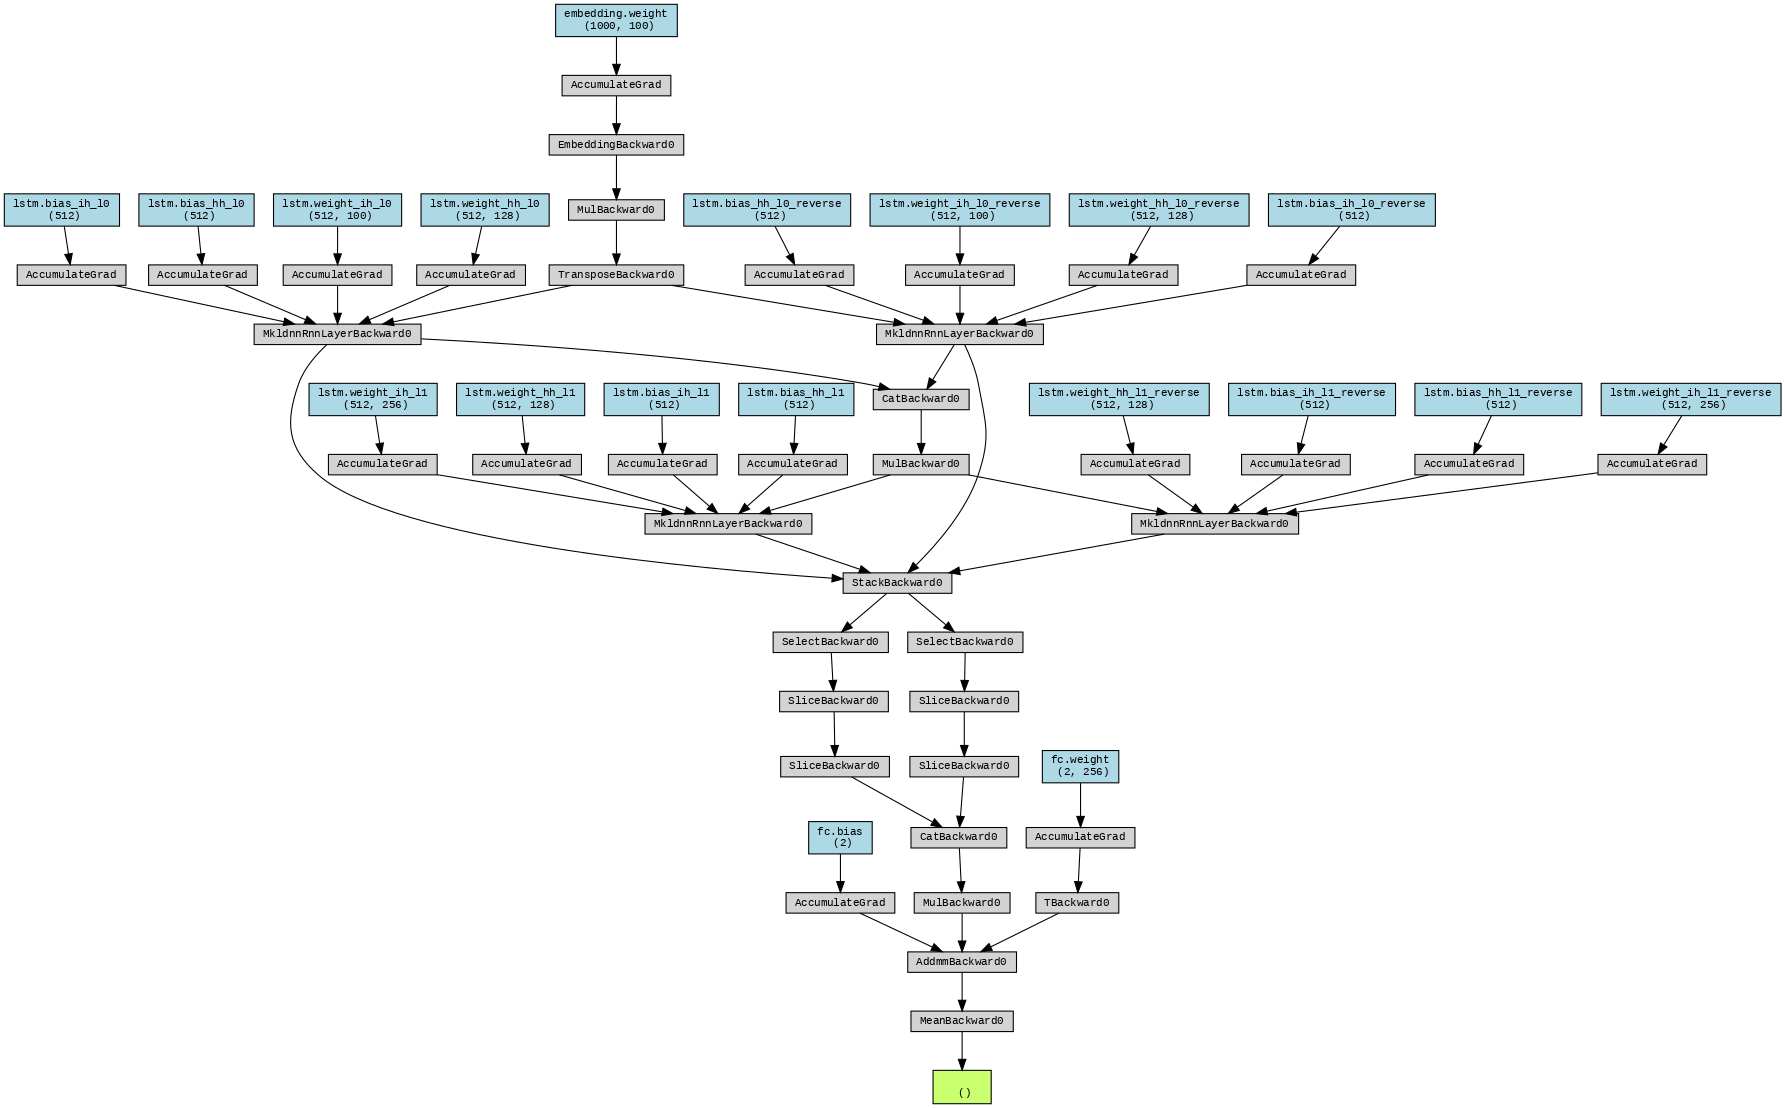

In [17]:
# Create computation graph for LSTM
print("\nCreating LSTM Computation Graph...")

dummy_input = torch.randint(0, 1000, (1, 10))
output = classifier(dummy_input)

graph = make_dot(output.mean(), params=dict(classifier.named_parameters()))
graph.render("lstm_classifier", format="png", cleanup=True)
print("Graph saved as 'lstm_classifier.png'")

display(Image('lstm_classifier.png'))

#Encoder-Decoder Architecture

"Encoder-decoder models are used when the input and output sequences can have different lengths and don't align word-to-word (e.g., translation)"

In [29]:
class EncoderRNN(nn.Module):
  """
  Encoder for sequence-to-sequence models
  The final hidden state h_n^e (^e superscript to mark the encoder) becomes the context vector c.
  """

  def __init__(self, input_size, hidden_size, num_layers=1):
    super(EncoderRNN, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # Embedding for the source vocab
    self.embedding = nn.Embedding(input_size, hidden_size)


    # Encoder with LSTM (could be also GRU or RNN, the author recommends the BiLSTMs)
    self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)

  def forward(self, input_seq):
    """
    Input to seqence representation

    input: Shape: (batch, sequence length)

    output: All hidden states from all time steps. Shape: (batch, seq_len, hidden_dim * num_directions)

    hidden: Final hidden state from all layers. Shape: (num_layers * num_directions, batch, hidden_dim)

    cell: Final cell state from all layers. Shape: (num_layers * num_directions, batch, hidden_dim). It is the final "memory vector" that stores long-term information from each LSTM layer.
    """

    # Embeddings
    embedded = self.embedding(input_seq)

    # Encoding with LSTM
    output, (hidden, cell) = self.lstm(embedded)

    # hidden is shape h_n^e (^e superscript to mark the encoder) and becomes the Context C for the basic model
    return(output, hidden, cell)




In [30]:
class DecoderRNN(nn.Module):
  """
  Docoder for seq-to-seq
  C is the context for the encoder
  """

  def __init__(self, hidden_size, output_size, num_layers=1):
    super(DecoderRNN, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # Embedding
    self.embedding = nn.Embedding(output_size, hidden_size)

    # LSTM Decoder
    self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)

    # Output projection to output vocab size
    self.out = nn.Linear(hidden_size, output_size)


  def forward(self, input_token, hidden, cell):
    """
    Decode in one step.

    input_token: (batch_size, 1) - previous output or <s> token

    hidden, cell: hidden and cell states (context from encoder when starts)
    """

    # Embedding prev output token
    embedded = self.embedding(input_token)


    # Decode in one step
    output, (hidden, cell) = self.lstm(embedded,(hidden, cell))

    # Projection to vocab size
    prediction = self.out(output)

    return(prediction, hidden, cell)

In [31]:
class Seq2Seq(nn.Module):
  """
  Complete encoder-decoder model

  Encoder-decoder networks, sometimes called
    sequence-to-sequence networks, are models capable of generating
    contextually appropriate, arbitrary length output sequences.

  """

  def __init__(self, encoder, decoder):
    super(Seq2Seq, self).__init__()

    self.encoder = encoder
    self.decoder = decoder

  def forward(self, source, target, teacher_forcing_ratio = 0.5):
    """
    Forward pass with teaching forcing, using always the gold label for the next token training as input

    source: source seq (batch_size, source_seq_len)
    target: source seq (batch_size, target_seq_len)

    teacher_forcing_ratio: probability of using teacher forcing

    """

    batch_size = source.size(0)
    target_len = target.size(1)

    target_vocab_size = self.decoder.out.out_features

    # Store decoder outputs
    outputs = torch.zeros(batch_size, target_len, target_vocab_size)

    # Encode source sequence to get contxt; "c = h_n^e"  (context is final encoder hidden state) (^e superscript to mark the encoder)
    encoder_outputs, hidden, cell = self.encoder(source)

    # First decoder input is start token <s> btwn source and target
    decoder_input = target[:, 0].unsqueeze(1)

    for t in range(1, target_len):
      # Decoding in one step
      decoder_output, hidden, cell = self.decoder(decoder_input, hidden, cell)
      outputs[:, t] = decoder_output.squeeze(1)

      # Teacher forcing
      use_teacher_forcing = np.random.random() < teacher_forcing_ratio

      if use_teacher_forcing:
        # Use actual nxt tkn (gold label)
        decoder_input = target[:, t].unsqueeze(1)

      else:
        # Using the models latest prediction (autoregressive)
        decoder_input = decoder_output.argmax(dim=2)

    return(outputs)

### Simple Test

Seq2Seq(
  (encoder): EncoderRNN(
    (embedding): Embedding(1000, 256)
    (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(1000, 256)
    (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
    (out): Linear(in_features=256, out_features=1000, bias=True)
  )
)
ENCODER-DECODER MODEL TEST

Input shapes:
  Source: torch.Size([2, 10])
  Target: torch.Size([2, 12])

Output shape: torch.Size([2, 12, 1000])
  (batch=2, target_len=12, vocab=1000)

MODEL SUMMARY
Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [2, 12, 1000]             --
├─EncoderRNN: 1-1                        [2, 10, 256]              --
│    └─Embedding: 2-1                    [2, 10, 256]              256,000
│    └─LSTM: 2-2                         [2, 10, 256]              1,052,672
├─DecoderRNN: 1-2                        [2, 1, 1000]              --
│    └─Embedding: 2-3                 

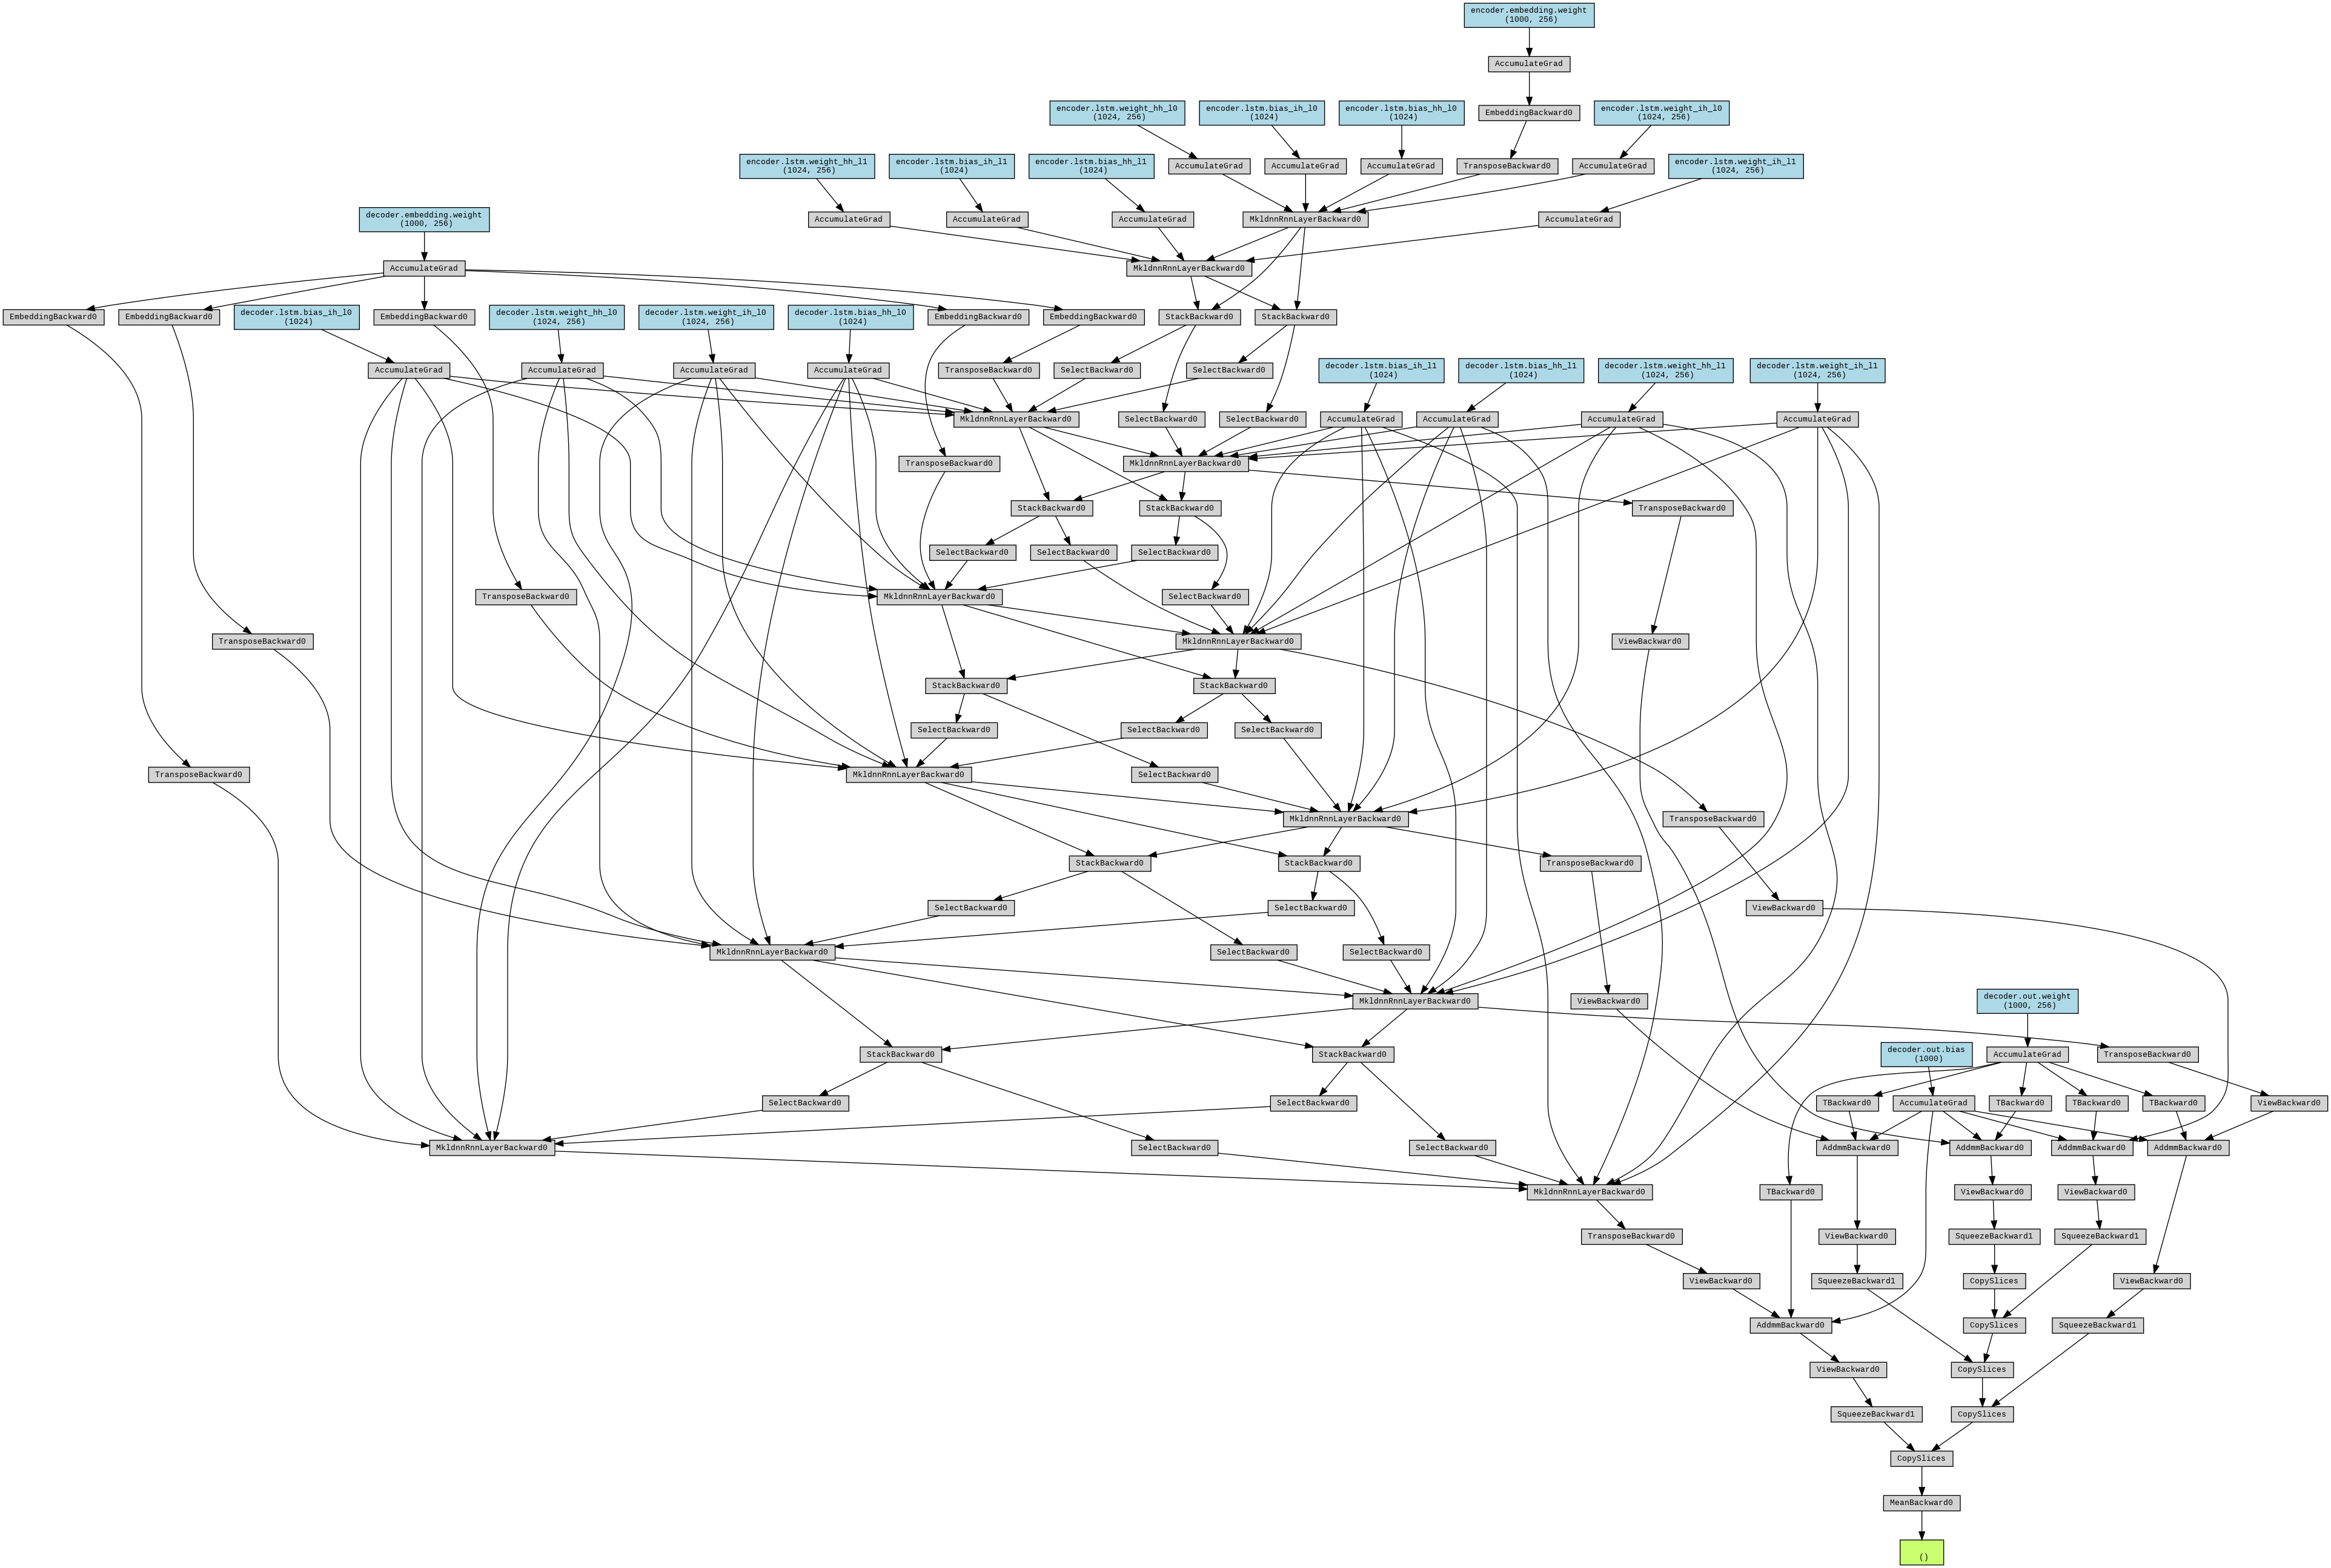


Total parameters: 2,874,344


In [42]:
# Create encoder-decoder model
input_vocab_size = 1000   # Source language vocabulary
output_vocab_size = 1000  # Target language vocabulary
hidden_size = 256

encoder = EncoderRNN(input_vocab_size, hidden_size, num_layers=2)
decoder = DecoderRNN(hidden_size, output_vocab_size, num_layers=2)
seq2seq = Seq2Seq(encoder, decoder)

print(seq2seq)


print("="*60)
print("ENCODER-DECODER MODEL TEST")
print("="*60)

# Test forward pass
batch_size = 2
source_len = 10
target_len = 12

source = torch.randint(0, input_vocab_size, (batch_size, source_len))
target = torch.randint(0, output_vocab_size, (batch_size, target_len))

print(f"\nInput shapes:")
print(f"  Source: {source.shape}")
print(f"  Target: {target.shape}")

# Forward pass
outputs = seq2seq(source, target, teacher_forcing_ratio=1.0)
print(f"\nOutput shape: {outputs.shape}")
print(f"  (batch={batch_size}, target_len={target_len}, vocab={output_vocab_size})")

# Torchinfo summary
print("\n" + "="*60)
print("MODEL SUMMARY")
print("="*60)
print(summary(seq2seq, input_data=[source, target], depth=2, verbose=0))
# Torchviz graph
print("\n" + "="*60)
print("COMPUTATION GRAPH")
print("="*60)

# Smaller input for cleaner graph
small_source = torch.randint(0, input_vocab_size, (1, 5))
small_target = torch.randint(0, output_vocab_size, (1, 6))

outputs = seq2seq(small_source, small_target)
graph = make_dot(outputs.mean(), params=dict(seq2seq.named_parameters()))
graph.render("encoder_decoder", format="png", cleanup=True)
print("Graph saved as 'encoder_decoder.png'")

# Display
display(Image('encoder_decoder.png'))

# Quick parameter count
total_params = sum(p.numel() for p in seq2seq.parameters())
print(f"\nTotal parameters: {total_params:,}")
